# Quick start

The main _histpy_ class is [Histogram](../api/histogram.rst) which is in essence an array with attached axes that define the bin edges. It can handle an arbitrary number of dimensions, be accessed in a similar way as a numpy array, projected, sliced, multiplied, fitted, plotted, etc. This is an overview of all of these features. More details can be found in the [API](../api/index.rst) documentation.

## Initialization

A Histogram object is defined by a series of bin edges (one more than the number of bins)

In [1]:
from histpy import Histogram
import numpy as np

h = Histogram(np.linspace(0,10,101))

The edges become part of the histograms' [Axis](../api/axis.rst)

In [2]:
print("Number of bins:".format(h.axis.nbins))
print("Bin centroids: {}".format(h.axis.centers))

Number of bins:
Bin centroids: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65 5.75 5.85 5.95 6.05 6.15 6.25 6.35 6.45 6.55 6.65 6.75 6.85 6.95
 7.05 7.15 7.25 7.35 7.45 7.55 7.65 7.75 7.85 7.95 8.05 8.15 8.25 8.35
 8.45 8.55 8.65 8.75 8.85 8.95 9.05 9.15 9.25 9.35 9.45 9.55 9.65 9.75
 9.85 9.95]


Specify the edges for multiple axes to get a histogram with an arbitrary number of dimensions. You can label the axes.

In [3]:
h2D = Histogram([np.linspace(10,20,201), np.linspace(0,5,101)], labels = ['x','y'])

for axis in h2D.axes:
    print("Axis '{}' has {} bins".format(axis.label, axis.nbins))

Axis 'x' has 200 bins
Axis 'y' has 100 bins


## Filling

You can fill the histogram entry by entry

In [4]:
for x in np.random.normal(loc = 5, scale = 2, size = 10000):
    h.fill(x)

Or all at once

In [5]:
x = np.random.normal(loc = 16, scale = 3, size = 10000)
y = np.random.normal(loc = 3, scale = 1, size = 10000)

h2D.fill(x,y)

## Plotting

You can plot 1D and 2D histograms using `draw()`.

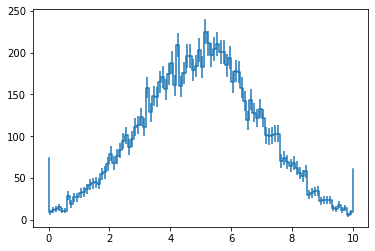

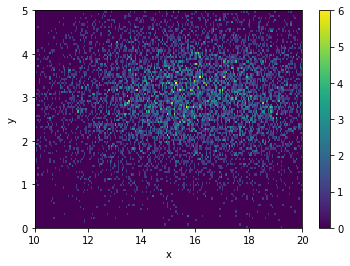

In [6]:
h.draw()

h2D.draw();

You might have noticed the two "peaks" on both ends of the 1D histogram. These represent the underflow and overflow contents. These are tracked by the histogram by default, but you have the option not to by setting `track_overflow = false` during initialization or by calling `.track_overflow(false)`.

The histograms are plotted using matplotlib. In the case of 1D histograms, `draw()` is a wrapper for [`errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html), and respectively [`pcolormesh`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html) for 2D histograms. You can customize the plots as usual.

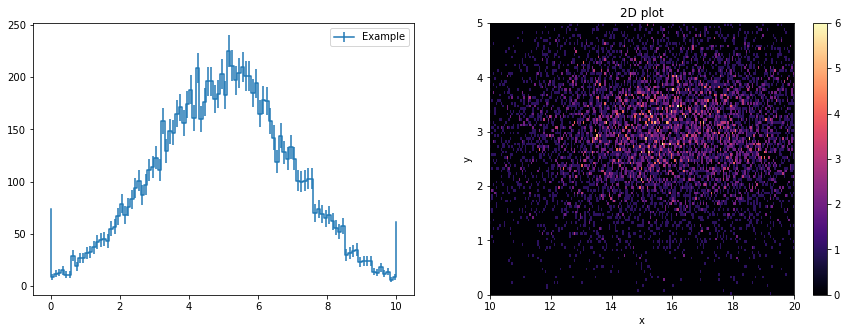

In [7]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(ncols = 2, figsize = [15,5])

h.draw(ax[0], label = "Example")
ax[0].legend()

h2D.draw(ax[1], cmap = 'magma')
ax[1].set_title("2D plot");

## Indexing

For the most part, the contents of a histogram can be accessed the same way as a numpy array

In [8]:
# Accessing the contents on a bin
h[50]

183.0

In [9]:
# A range
h[50:60]

array([183., 225., 211., 197., 204., 210., 201., 201., 185., 194.])

In [10]:
# A list of bins
h[[0,50,80]]

array([  9., 183.,  68.])

In [11]:
# Boolean mask
h[h > .9*np.max(h)]

array([209., 203., 225., 211., 204., 210.])

However, the `-1` bin <font color='red'><ins>**DOES NOT**</ins></font> correspond to the last bin, but rather to the *underflow* bin. Similarly, the bin equal to the total number of bins is the overflow bin. 

In [12]:
# Underflow
h[-1]

74.0

In [13]:
# Overflow
h[h.nbins]

61.0

The special constant `end` can be used to access any bin relative to the last one, e.g.
```python
h[h.end-10] <-> h[h.nbins-10]
```

This is specially useful for multi-dimensional histograms, where the property `nbins` is not a number, but a sequence. Use `end` instead and it will be automatically replaced by the number of bins in that dimension

In [14]:
# Here we initialize a histogram with non-zero contents
# All bin contents equal 1 expect the underflow/overflow bin
# You can initialize them as well, but in this case they are empty
h = Histogram([np.linspace(0,6,7), np.linspace(0,4,5)], contents = np.ones((6,4)), labels = {'x', 'y'})

print("Number of dimensions: {}".format(h.ndim))
print("Number of bins on each axis: {}".format(h.nbins))

# DO NOT do this. 
# h[:, h.nbins-1] is equivalent to h[:, [5,3]] and will raise an out-of-bounds exception (in this case)
#h[:, h.nbins-1] 

# DO this
print("Last y-bin: {}".format(h[:, h.end-1]))

Number of dimensions: 2
Number of bins on each axis: [6 4]
Last y-bin: [1. 1. 1. 1. 1. 1.]


You might want to select all bins, including the underflow and overflow bins. You can use `h[-1:h.end+1]` however this can get cumbersome for multi-dimensional histograms since the implicit index for unspecified dimensions is `:`, which doesn't include underflow/overflow:

In [15]:
h[0] # = h[0,:]

array([1., 1., 1., 1.])

If you want to include these special bins for all the reminding axes use `...` (the Ellipsis object)

In [16]:
h[0,...] # = h[0, -1:h.end+1]

array([0., 1., 1., 1., 1., 0.])

The following aliases are provided just for convenience and readability
```python
h.uf = -1
h.of = h.end
h.all = slice(-1,h.end+1) # i.e. h[h.all] -> h[-1:h.end+1] 
```

<div class="alert alert-warning">
NOTE: Negative indices DO NOT correpond to bins counting from the end. <tt>h[-1]</tt> corresponds to the underflow bin and other negative values will raise an <tt>IndexError</tt>. Use instead e.g. <tt>h[h.nbins-1]</tt> or <tt>h[h.end-3]</tt>.
</div>

Attempting to access an underflow/overflow bin when they are not tracked (see `track_overflow()`) will result in an `IndexError`. If the under/overflow is not tracked, then
```python
h.all = slice(0,h.end) # i.e. h[h.all] -> h[0:h.end] 
```

## Weighted histograms

You can also fill the histograms using weighted data. If you care about statistical errors though you'll want to set `sumw2=True` while initializaing the histogram. The histogram will then save the sum of the weights squared for each bin ($\sum w_i^2$). The bin errors will then be $\sqrt{\sum w_i^2}$ (assuming Gaussian statistics) as opposed to $\sqrt{N}$. 

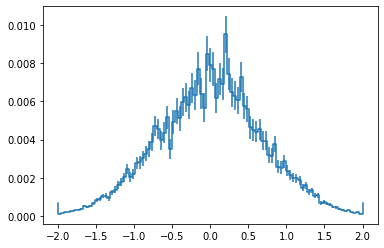

In [17]:
h = Histogram(np.linspace(-2,2, 100), sumw2 = True)

nsamples = 10000
x = np.random.uniform(low=-3, high=3, size=nsamples)

h.fill(x, weight = np.exp(-x*x)/nsamples)

h.draw();

The individual stored values can be accessed using `sumw2[]`

In [18]:
print("Bin {}: {:.2e} +/- {:.2e}".format(50, h[50], np.sqrt(h.sumw2[50])))

Bin 50: 7.69e-03 +/- 8.76e-04


## Slice and project

You might have noticed that when you slice a histogram using `[]` the output is an array with the corresponding contents. By using `slice[]` you can instead obtain a `Histogram` object, which contains both contents and axes

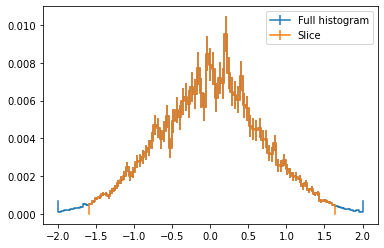

In [19]:
ax,plot = h.draw(label = "Full histogram")

h.slice[10:90].draw(ax, label = "Slice")

ax.legend();

You can also project a multi-dimensional histogram onto one or more axes, reducing the number of dimensions

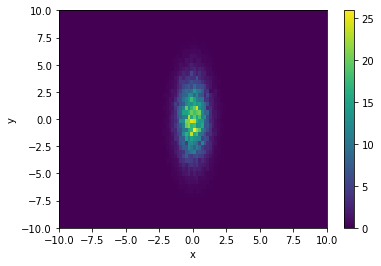

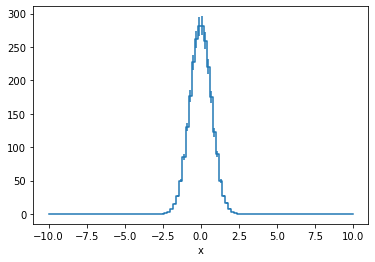

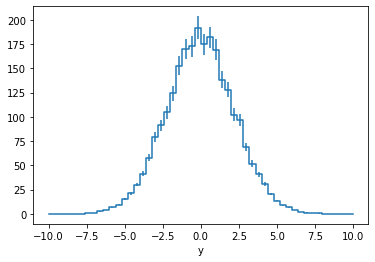

In [20]:
x_edges = np.linspace(-10,10,101)
y_edges = np.linspace(-10,10,51)

h = Histogram([x_edges, y_edges], labels = ['x','y'], sumw2 = True)

x = np.random.uniform(low=-10, high=10, size=100000)
y = np.random.uniform(low=-10, high=10, size=100000)

h.fill([x,y], weight = np.exp(-x*x-y*y/10))

h.draw()

h.project('x').draw()

h.project('y').draw();

Because `slice` always returns a histogram of the same dimensionality as the original, no matter the number of selected bin, if you want to get a "cross section" then you need to slice *and* project

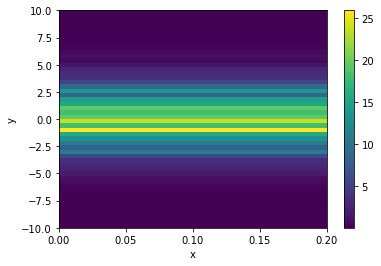

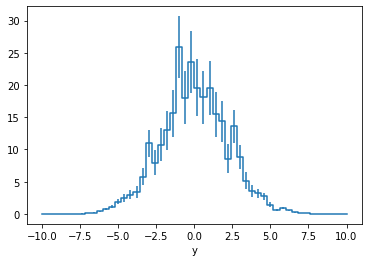

In [21]:
h.slice[50].draw()

h.slice[50].project('y').draw();

## Interpolation and rebinning

Basic rebinning and linear interpolation is also provided

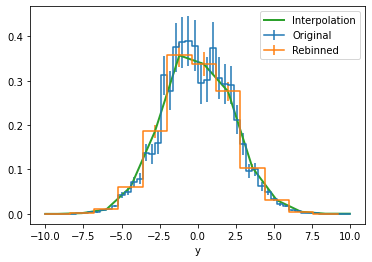

In [22]:
# 1D example

# First we take a slice as before
h_slice = h.slice[30:40].project('y')

ax,plot = h_slice.draw(label = "Original")

# Rebining sums N bins together. 
# Here we divide by N to obtain the average
h_rebin = h_slice.rebin(4)/4

h_rebin.draw(ax, label = "Rebinned")

# Interpolating at the original bin centroids
x = np.linspace(-10,10,51)

ax.plot(x, h_rebin.interp(x), linewidth = 2, label = "Interpolation");

ax.legend()

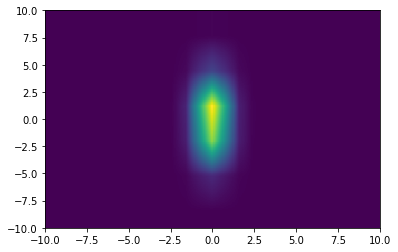

In [23]:
# 2D example

# Rebinning
h_rebin = h.rebin(4,8)

# e.g Interpolating a 2D histogram
x = np.linspace(-10,10,301)
y = np.linspace(-10,10,301)
X,Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)

plt.pcolormesh(x,y, h_rebin.interp(X,Y));

## Binary operations

`Histogram` supports arithmethic binary operations (`+`, `-`, `*`, `/`), either againts other `Histogram` objects, scalars or arrays of an appropiate size. Make sure to set `sumw2=True` during initialization so the errors are propagated appropiately. 

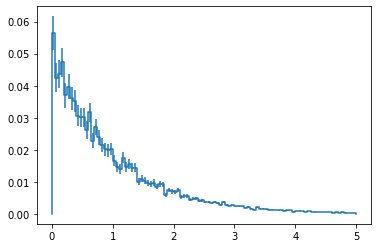

In [24]:
# e.g. normalizing a histogram
h = Histogram(np.linspace(0,5, 101), sumw2 = True)

x = np.random.uniform(0,5, size = 10000)
h.fill(x, weight = np.exp(-x))

h /= np.sum(h)

h.draw();

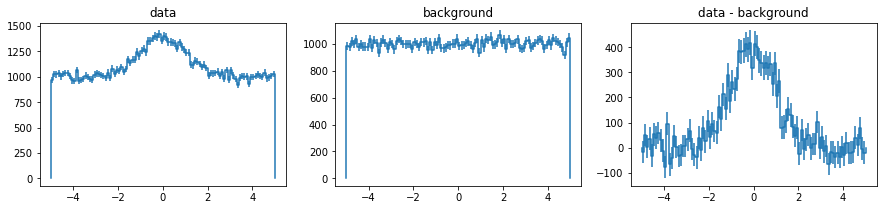

In [25]:
# e.g. substracting a background

fig,ax =  plt.subplots(ncols = 3, figsize = [15,3])

# Source + background histogram
h = Histogram(np.linspace(-5,5, 101), sumw2 = True)

x = np.random.normal(size = 10000)
h.fill(x)

bkg = np.random.uniform(-5,5, size = 100000)
h.fill(bkg)

h.draw(ax[0])

ax[0].set_title("data")

# Background only histogram
h_b = Histogram(np.linspace(-5,5, 101), sumw2 = True)

bkg = np.random.uniform(-5,5, size = 100000)
h_b.fill(bkg)

h_b.draw(ax[1])

ax[1].set_title("background")

# Brackground-subtrated histogram

h_s = h-h_b
h_s.draw(ax[2])

ax[2].set_title("data - background");

## Fitting

A convenient wrapper of scipy's [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html]) is provided. All user parameters are passed along together with the histogram's data.

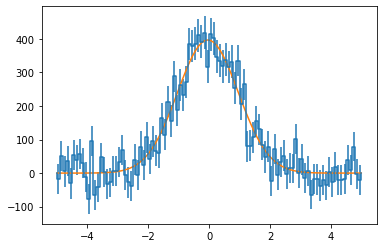

In [26]:
# Define a function to fit
def f(x, N, x0, var):
    return N*np.exp(-(x-x0)**2/2/var)

# Histogram will pass the initial guess (p0) to scipy curve_fit
sol,cov = h_s.fit(f, p0 = [500,1,2])

# Plot result
x = np.linspace(-5,5,100)

ax,_ = h_s.draw()

ax.plot(x, f(x, *sol));

## Disk I/O

Lastly, you can save the histogram to disk as an [HDF5](https://docs.h5py.org) file

In [27]:
h.write("hist.h5")

In [28]:
h2 = Histogram.open("hist.h5")

In [29]:
h == h2

True

## Sparse histograms

Sparse histogram are useful when most of the bins will be empty. This allows to handle a large number of bins or dimensions that would otherwise might be resource prohibitive. 

For example, let's create an spase histogram with 10^12 bins:

In [30]:
h = Histogram([np.linspace(0,100,101) for n in range(6)], sparse = True)

Sparse histogram are handled the same way as regular dense histogram, and for the most part you don't have to write code specific for them. 

In this example we'll fill the histogram with 6 fully corelated variables, each with a small statistical error:

In [31]:
nsamples = 1000

h.fill(np.random.uniform(0,100,nsamples) + np.random.normal(size = (h.ndim,nsamples)))

You can then perform any operation as usual:

(<AxesSubplot:>, <matplotlib.collections.QuadMesh at 0x7fe919747fd0>)

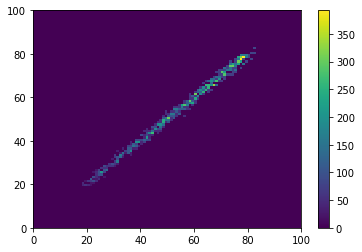

In [32]:
# Slice along the 5th axis
h = h.slice[{4:slice(20,80)}]

# Linear weight along the 3rd axis
h *= h.expand_dims(h.axes[2].centers, 2)

# Project onto the first 2 axes
h = h.project(0,1)

h.plot()

The main difference is that sparse histograms return [SparseArrays](https://sparse.pydata.org/) instead of regular numpy arrays

In [33]:
type(h.contents)

sparse._coo.core.COO

You can transform a sparse histogram into a regular one using `to_dense()`

In [34]:
type(h.to_dense().contents)

numpy.ndarray

<div class="alert alert-warning">
NOTE: When working with sparse histograms, and for optimal efficiency, complete the filling process before performing operations —e.g. projections, slices, arithmetics, etc. There is an overhead required to prepare the histogram for contents modification.
</div>

<div class="alert alert-warning">
NOTE: <tt>SparseArray</tt> do not yet fully supports numpy's advance indexing —i.e. using an index array. Accessing the contents with a one-dimensional array works —e.g. <tt>h[[0,3,7]]</tt>, but multiple dimensional array —e.g. <tt>h[[[0,3,7]]]</tt>— and setting multiple bins —e.g. <tt>h[[0,3,7]] = 1</tt>— does not.
</div>